# Diferentes tipos de rendimiento

In [1]:
# Bajamos los ETF de yahoo
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tickers = ['VOO', 'NAFTRAC.MX']
start_date = '2015-01-01'
end_date = '2024-01-01'
St = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  2 of 2 completed


In [2]:
# Obten rendimientos
rt = St.pct_change()

In [4]:
# Rendiiento aritmetico VOO
(St.VOO[-1] - St.VOO[0]) / St.VOO[0]

1.7350303454630471

In [5]:
(St.VOO[-1] / St.VOO[0]) - 1

1.7350303454630471

In [7]:
(1 + rt.VOO).prod() - 1

1.7350303454630525

In [9]:
# Rendimiento geometrico
rg_diario = (1 + rt.VOO).prod()**(1/len(rt)) - 1
rg_anual = rg_diario * 252
rg_anual

0.11201601841417741

$$PrecioInicial* (1 + r_g)^N = PrecioFinal$$

In [11]:
# Sacalo anual, interpretalo
St.VOO[0] * (1 + rg_diario) ** 2264

436.799987792861

In [ ]:
# Comprobación


In [12]:
# Valores esperados acciones
ve_usa = rt.VOO.mean()
ve_mx = rt["NAFTRAC.MX"].mean()

# Volatilidad acciones
s_usa = rt.VOO.std()
s_mx = rt["NAFTRAC.MX"].std()

# Correlacion
corr_usa_mx =  rt.corr()["NAFTRAC.MX"]["VOO"]

# Covarianza
cov_usa_mx =  rt.cov()["NAFTRAC.MX"]["VOO"]


$$\sigma^2_p = w_a^2 \sigma^2_a + w_b^2 \sigma_{b}^2 + 2 w_a w_b cov(a,b)$$


$$cov(a,b) = \sigma_a \sigma_b corr(a,b) $$

$$\sigma^2_p = w_a^2 \sigma^2_a + w_b^2 \sigma_{b}^2 + 2 w_a w_b \sigma_a \sigma_b corr(a,b)$$


In [21]:
# Crea data frame con distintas correlaciones
def volatility_correlation(df, s_usa, s_mx, correlation):
    w1 = df['w_usa']
    w2 = df['w_mx']
    var_p = w1**2 * s_usa**2 + w2**2 * s_mx**2 + 2*w1*w2*correlation*s_usa*s_mx
    vol_p = np.sqrt(var_p)
    return vol_p

w = np.linspace(0, 1, 100)
df = pd.DataFrame({
    'w_usa': w,
    'w_mx': 1 - w,
    'valor_esperado': (w*ve_usa  + (1-w) * ve_mx) * 252
})

# Obten la volatilidad real, correlacion -1, 1, 0


In [26]:
df['volatility'] = df.apply(lambda x: volatility_correlation(x, s_usa, s_mx, corr_usa_mx), axis = 1) * np.sqrt(252)
df['volatility_0'] = df.apply(lambda x: volatility_correlation(x, s_usa, s_mx, 0), axis = 1) * np.sqrt(252)
df['volatility_-1'] = df.apply(lambda x: volatility_correlation(x, s_usa, s_mx, -1), axis = 1) * np.sqrt(252)
df['volatility_1'] = df.apply(lambda x: volatility_correlation(x, s_usa, s_mx, 1), axis = 1) * np.sqrt(252)

Text(0, 0.5, '$E[x]$')

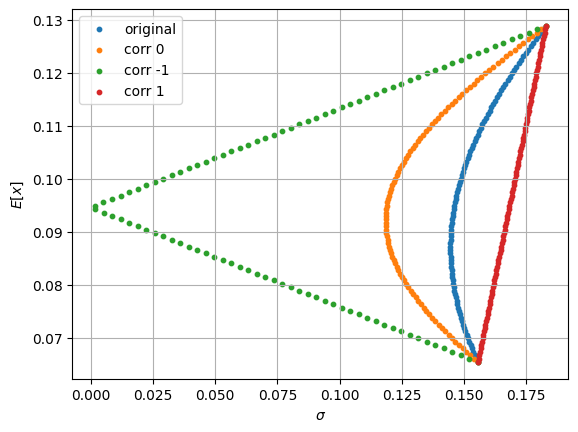

In [30]:
# Como se ve con la real?
plt.scatter(df.volatility, df.valor_esperado, label = "original", s=10)
plt.scatter(df.volatility_0, df.valor_esperado, label = "corr 0", s=10)
plt.scatter(df['volatility_-1'], df.valor_esperado, label = "corr -1", s=10)
plt.scatter(df.volatility_1, df.valor_esperado, label = "corr 1",s=10)

plt.grid()
plt.legend()
plt.xlabel("$\sigma$")
plt.ylabel("$E[x]$")
# Cra distintas correlaciones

## Varios activos

In [31]:
tickers = ['VOO', 'VEA', 'VWO', 'VNQ', 'NAFTRAC.MX']
start_date = '2015-01-01'
end_date = '2021-01-01'
St = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
rt = St.pct_change()

[*********************100%%**********************]  5 of 5 completed


$$Varianza = W * \Sigma * W^t $$
$$VE = W^T E[r]$$

In [38]:
# Crea una función que retorne el rendimiento esperado y la varianza de un portafolio
def random_portafolio(returns):
    def rand_weights(n):
        k = np.random.rand(n)
        return k / sum(k)
    # Definimos las constantes
    means = rt.mean()
    sigma = returns.cov()
    # Obtenemos pesos
    n_act = len(rt.keys())
    w = rand_weights(n_act)
    # Rendimiento esperado anual
    re = w.dot(means)
    # Varianza
    var = w.dot(sigma).dot(w)
    vol = var **(1/2)

    # Retorna rendimiento esperado, volatilidad y pesos
    return re * 252, vol * 252**(1/2), w

random_portafolio(rt)

(0.08595371388596688,
 0.1646840738328688,
 array([0.20541152, 0.13255388, 0.23602976, 0.25235479, 0.17365004]))

In [42]:
# Simula 500 portafolios
valores_esperados = []
volatilidades = []
pesos = []
for i in range(5000):
    ve_i, vol_i, pesos_i = random_portafolio(rt)
    valores_esperados.append(ve_i)
    volatilidades.append(vol_i)
    pesos.append(pesos_i)

df = pd.DataFrame({
    "w": pesos,
    "rendimeinto_esperado": valores_esperados,
    "volatilidad": volatilidades
})
df

,w,rendimeinto_esperado,volatilidad
0,"[0.43175981223961657, 0.13829622263605656, 0.1...",0.072444,0.151670
1,"[0.1306472709942238, 0.0745850585568847, 0.189...",0.089620,0.173724
2,"[0.23468157989239716, 0.2161315926723518, 0.09...",0.085387,0.163188
3,"[0.3866381518856028, 0.15198660616550047, 0.02...",0.084136,0.154304
4,"[0.05257865246635276, 0.3278284133284485, 0.06...",0.105763,0.174504
...,...,...,...
4995,"[0.3227404328641303, 0.052769544684582115, 0.2...",0.080514,0.158314
4996,"[0.17213360450046722, 0.3077695025265373, 0.14...",0.081227,0.168177
4997,"[0.18364467163860396, 0.05746736114879322, 0.2...",0.087109,0.167763
4998,"[0.04020192000031446, 0.3609974793808507, 0.02...",0.094663,0.180994


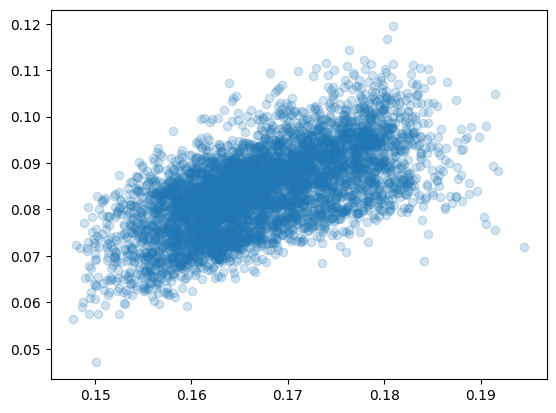

In [47]:

# Grafica
plt.scatter(df.volatilidad, df.rendimeinto_esperado, alpha=0.2)

# ¿en que invertir para obtener el de mínima varianza?

In [48]:
min_var = df[df.volatilidad == df.volatilidad.min()]
min_var["w"].values

array([array([0.66931465, 0.06006601, 0.16637293, 0.10026257, 0.00398384])],
      dtype=object)

# Más riesgo, más volatilidad? Crea una regresión

Más riesgo, más volatilidad porque mientras más volatil, más barato

In [49]:
df_regresion = pd.DataFrame({
    "valor_esperado": rt.mean() * 252,
    "volatilidad": rt.std() * 252**(1/2)
})

In [50]:
from sklearn.linear_model import LinearRegression

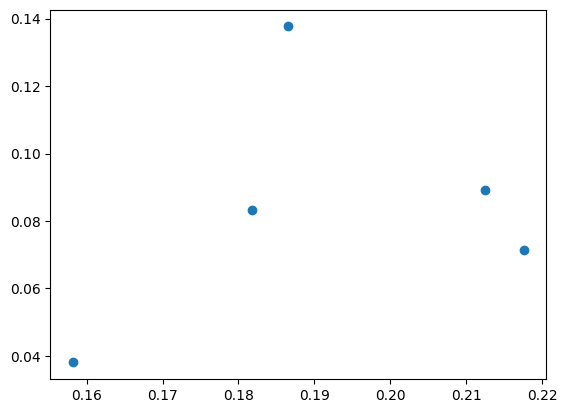

In [51]:
plt.scatter(df_regresion.volatilidad, df_regresion.valor_esperado)

In [52]:
model = LinearRegression()
X = df_regresion[["volatilidad"]]
y = df_regresion[["valor_esperado"]]

model.fit(X,y)

LinearRegression()

In [53]:
model.intercept_

array([-0.00192929])

In [54]:
model.coef_

array([[0.44874541]])

# Escriber la ecuación

In [61]:
print("Rendimiento = " + str(model.intercept_[0]) + " + " + str(model.coef_[0][0]) + " * vol")

Rendimiento = -0.0019292851870956335 + 0.44874541383738803 * vol


In [62]:
df_regresion["predicciones"] = model.predict(X)

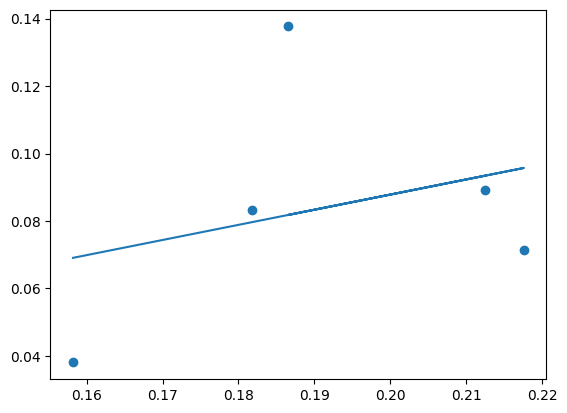

In [64]:
plt.scatter(df_regresion.volatilidad, df_regresion.valor_esperado)
plt.plot(df_regresion.volatilidad, df_regresion.predicciones)

## Calcular error del modelo

In [66]:
error_modelo = np.var(df_regresion["predicciones"] - df_regresion["valor_esperado"])
error_promedio = np.var(df_regresion["valor_esperado"].mean() - df_regresion["valor_esperado"])

In [67]:
(error_promedio - error_modelo) / error_promedio

0.09133025026745581

In [69]:
from sklearn.metrics import r2_score
r2_score(y_true=y, y_pred=df_regresion["predicciones"])

0.09133025026745611